Clustering
===
*Bothound project*

# Initialization

In [159]:
# initialization
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.spatial.distance import cdist,pdist
from scipy.signal import argrelextrema
%matplotlib inline
from pylab import *
from numpy import *
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from scipy.stats import itemfreq

# boeh
from collections import OrderedDict
import pandas as pd
import bokeh.plotting as bk
bk.output_notebook()
from bokeh.charts import Bar
from bokeh.charts import Histogram

# enabling folding extension. Run it once.
import notebook
E = notebook.nbextensions.EnableNBExtensionApp()
E.enable_nbextension('usability/codefolding/main')

import yaml
from bothound_tools import BothoundTools

color_set = [
    [0, 0, 255],      #Blue
    [255, 0, 0],      #Red
    [0, 255, 0],      #Green
    [255, 255, 0],    #Yellow
    [255, 0, 255],    #Magenta
    [255, 128, 128],  #Pink
    [128, 128, 128],  #Gray
    [128, 0, 0],      #Brown
    [255, 128, 0],    #Orange
]

def get_palette(N=5):
    result = []
    for x in range(N):
        s = color_set[x % len(color_set)]
        result.append([s[0]/255.0,s[1]/255.0,s[2]/255.0,1])
    return result
palette = get_palette(30)

def plot_costs(costs, num_clusters, title):
    KK = range(1,len(costs)+1)

    # elbow curve
    kIdx = num_clusters      
    clr = cm.spectral( np.linspace(0,1,10) ).tolist()
    mrk = 'os^p<dvh8>+x.'

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(KK, costs, 'b*-')
    ax.plot(num_clusters, costs[num_clusters-1], marker='o', markersize=14, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    #ax.set_ylim((0,100))
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within sum of squeres')
    plt.title(title)
    
def plot_clusters(clusters, num_clusters,title="Histogram"):
    sizes = [0]*num_clusters
    for i in clusters: 
        if(i >= 0) :
            if (i >= num_clusters):
                print i
            sizes[i] = sizes[i]+1
    print (sizes)
    
      #plot histogramm
    left = [] 
    for i in range(len(sizes)):
        left.append(i-0.5)
    fig = plt.figure()
    plt.title(title)
    ax = fig.add_subplot(111)
    ax.bar(left,sizes, color = palette)            
    
    
def get_clustering_model(X, num_clusters):
    model = KMeans(n_clusters=num_clusters, precompute_distances = True, max_iter = 500, n_init = 30)
    model.fit(X)
    
    clusters = model.predict(X)
    plot_clusters(X, clusters, num_clusters)
    return clusters

def get_best_clustering_model(X, max_number_of_clusters, title):
    cost = []
    KK = range(1,max_number_of_clusters+1)
    kms = []
    # calculate all the clustering and cost
    for no_of_clusters in KK:
        km = KMeans(n_clusters=no_of_clusters, precompute_distances = True, max_iter = 500, n_init = 30)
        km.fit(X)
        kms.append(km)

        sizes = [0]*no_of_clusters
        for i in km.predict(X): 
            if(i >= no_of_clusters):
                print i
            sizes[i] = sizes[i]+1
        print (sizes)

        cost.append(km.inertia_)

    # calculate first derivative
    derivative1 = [cost[i+1]-cost[i] for i in range(len(cost)-1)]
    #print derivative1

    # calculate second derivative
    derivative2 = [derivative1[i+1]-derivative1[i] for i in range(len(derivative1)-1)]
    #print derivative2

    max2 = argrelextrema(np.argsort(derivative2), np.less) 
    num_clusters = 4 
    if(len(max2[0]) > 0):
        num_clusters = max2[0][0] + 3
    else:
        # calculate third derivative
        derivative3 = [derivative2[i+1]-derivative2[i] for i in range(len(derivative2)-1)]
        #print derivative3

        max3 = argrelextrema(np.argsort(derivative3), np.greater) 
        if(len(max3[0]) > 0):
            num_clusters = max3[0][0] + 4 

    model = kms[num_clusters-1]
    
    # plot costs
    plot_costs(cost, model.n_clusters, "Cost of k-Means." + title)

    clusters = model.predict(X)
    plot_clusters(clusters, model.n_clusters, title)
    return clusters, model.n_clusters, cost

def plot3(feature_indexes, X, clusters, selected_cluster):
    if(selected_cluster >= 0):
        X_plot = X[clusters == selected_cluster,: ]
        labels_plot = clusters[clusters == selected_cluster]
    else:
        X_plot = X[clusters >= 0,: ]
        labels_plot = clusters[clusters >= 0]
    
    colors = []
    for i in labels_plot:
        colors.append(palette[i])

    fig = figure(figsize=(24,24))
    ax = fig.gca(projection='3d')

    ax.set_xlabel(features[feature_indexes[0]])
    ax.set_ylabel(features[feature_indexes[1]])
    ax.set_zlabel(features[feature_indexes[2]])
    azim = 125
    elev = 15
    #ax.set_autoscale_on(False)
    ax.view_init(elev, azim) 

    # plot points in 3D
    class1 = 0.6 * random.standard_normal((200,3))
    x = X_plot[:,feature_indexes[0]]
    y = X_plot[:,feature_indexes[1]]
    z = X_plot[:,feature_indexes[2]]
    
    ax.scatter(x,y,z, s=5, edgecolors='none', c = colors, marker='o')

    #ax.set_xlim([-1,5])
    #ax.set_ylim([-1,5])
    #ax.set_zlim([-1,5])

def plot_intersection(clusters, num_clusters, id_incident, ips, id_incident2, cluster2 = -1):
    clusters_np = np.array(clusters)
    ips_np = np.array(ips)
    ips2 = set(tools.get_ips(id_incident2, cluster2))
    d = {}
    d["Cluster"] = []
    d["Incident"] = []
    d["data"] = []
    percentages = []
    intersections = []
    
    for cluster in range(0, num_clusters):
        d["Cluster"].append(cluster)
        d["Incident"].append("Unique from incident {}".format(id_incident))
        cluster_ips = set(ips_np[clusters_np == cluster])
        intersection = len(ips2.intersection(cluster_ips))
        intersections.append(intersection)
        d["data"].append(len(cluster_ips)-intersection)
        if(len(cluster_ips) == 0):
            percentages.append(0)
        else:
            percentages.append(intersection*100.0/len(cluster_ips))
        
    for cluster in range(0, num_clusters):
        d["Cluster"].append(cluster)
        d["Incident"].append("Intersection with incident {}".format(id_incident2))
        d["data"].append(intersections[cluster])
        
    df=pd.DataFrame(d)
    p=Bar(df,label='Cluster',values='data',stack='Incident',legend='top_right', 
          title = "Intersection. Incident {} vs. Incident {} (cluster={})".format(id_incident, id_incident2, cluster2) ,
         ylabel = "IP sessions", plot_width=1000, plot_height=600)
    bk.show(p)   

def plot_countries(clusters, num_clusters, sessions, num_countries = 10):
    countries = tools.get_countries()
    ids = np.array([s['id_country'] for s in sessions])
    #first find the best countries 
    if(num_countries > len(countries)):
        num_countries = len(countries)
      
    # find the most ccountries count in total
    freq = itemfreq(ids)
    sorted_countries = sorted(freq, key=lambda k: k[1], reverse=True) 
    best_countries = sorted_countries[0:num_countries]
    codes = []
    for i in range(0,len(best_countries)):
        c = (item for item in countries if item["id"] == best_countries[i][0]).next()
        codes.append(c)

    # calculate best countries count per cluster
    clusters_np = np.array(clusters)
    d = {}
    d["Cluster"] = []
    d["Country"] = []
    d["data"] = []
    freqs= []
    for cluster in range(0, num_clusters):
        ids_cluster = ids[clusters_np == cluster]
        freqs.append(itemfreq(ids_cluster))
        
    for i in range(0,len(best_countries)):
        for cluster in range(0, num_clusters):
            d["Cluster"].append(cluster)
            d["Country"].append(codes[i]["name"])
            exists = False
            for f in freqs[cluster]:
                if (f[0] == best_countries[i][0]):
                    d["data"].append(f[1])
                    exists = True
                    break
            if (not exists) :
                d["data"].append(0)

    df=pd.DataFrame(d)
    p=Bar(df,label='Cluster',values='data',stack='Country',legend='top_right', 
          title = "Countries" ,
         ylabel = "IP sessions", plot_width=1000, plot_height=600)
    bk.show(p)   
    
def plot_ban(clusters, num_clusters, sessions):
    clusters_np = np.array(clusters)
    bans = np.array([s['ban'] for s in sessions])
    d = {}
    d["Cluster"] = []
    d["Ban"] = []
    d["data"] = []
    banned = []
    percentage = []
    
    for cluster in range(0, num_clusters):
        d["Cluster"].append(cluster)
        d["Ban"].append("Served")
        cluster_total = bans[clusters_np == cluster]
        cluster_banned = cluster_total[cluster_total==1]
        banned.append(cluster_banned.shape[0])
        p = float("{0:.2f}".format(cluster_banned.shape[0]*100.0/cluster_total.shape[0]))
        percentage.append(p)
        d["data"].append(cluster_total.shape[0]-cluster_banned.shape[0])
          
    for cluster in range(0, num_clusters):
        d["Cluster"].append(cluster)
        d["Ban"].append("Banned")
        d["data"].append(banned[cluster])

    df=pd.DataFrame(d)
    p=Bar(df,label='Cluster',values='data',stack='Ban',legend='top_right', 
          title = "Banjax Ban" ,
         ylabel = "IP sessions", plot_width=1000, plot_height=600)
    bk.show(p)   
    print banned
    print percentage


Loading BokehJS ...

/usr/local/lib/python2.7/dist-packages/jupyter_core/application.py:78: DeprecationWarning: JupyterApp._config_dir_default is deprecated: use @default decorator instead.
  def _config_dir_default(self):
/usr/local/lib/python2.7/dist-packages/notebook/nbextensions.py:340: DeprecationWarning: EnableNBExtensionApp._config_file_name_default is deprecated: use @default decorator instead.
  def _config_file_name_default(self):
/usr/local/lib/python2.7/dist-packages/jupyter_core/application.py:91: DeprecationWarning: JupyterApp._data_dir_default is deprecated: use @default decorator instead.
  def _data_dir_default(self):
/usr/local/lib/python2.7/dist-packages/jupyter_core/application.py:73: DeprecationWarning: JupyterApp._jupyter_path_default is deprecated: use @default decorator instead.
  def _jupyter_path_default(self):
/usr/local/lib/python2.7/dist-packages/jupyter_core/application.py:69: DeprecationWarning: JupyterApp._log_level_default is deprecated: use @default decorator instead.
  de

# Configuration

In [12]:
#Report Configuration
id_incident = 20

features = [
    "request_interval", #1
    #"ua_change_rate",#2
    "html2image_ratio",#3
    "variance_request_interval",#4
    "payload_average",#5
    #"error_rate",#6
    #"request_depth",#7
    #"request_depth_std",#8
    "session_length",#9
    #"percentage_cons_requests",#10
]

max_number_of_clusters = 8

stram = open("../conf/bothound.yaml", "r")
conf = yaml.load(stram)
tools = BothoundTools(conf)
tools.connect_to_db()

# Read & Preprocess

In [13]:
# Reading from Database
incident = None
sessions = None
incident = tools.get_incident(id_incident)
sessions = tools.get_sessions(id_incident)
#tools.disconnect_from_db()

print ("Incident {} loaded:".format(id_incident))
print ("Start: {}".format(incident[0]["start"]))
print ("Stop : {}".format(incident[0]["stop"]))
#print ("Comment : {}".format(incident[0]["comment"]))
values = []
ips = []
for s in sessions:
    row = []
    for f in features:
        row.append(s[f])
    values.append(row)
    ips.append(s["IP"])
X = np.array(values)
print (X.shape)

# normalization 
std_scale = preprocessing.StandardScaler().fit(X)
X = std_scale.transform(X)


Incident 20 loaded:
Start: 2016-02-10 07:00:00
Stop : 2016-02-10 07:10:00
(13068, 5)


# PCA Clustering

[900]
[228, 672]
[671, 228, 1]
[671, 227, 1, 1]
[641, 225, 1, 32, 1]
[219, 308, 1, 31, 1, 340]
[339, 219, 1, 1, 308, 1, 31]
[339, 219, 1, 1, 30, 308, 1, 1]
[671, 227, 1, 1]
('Num clusters(PCA):', 4)


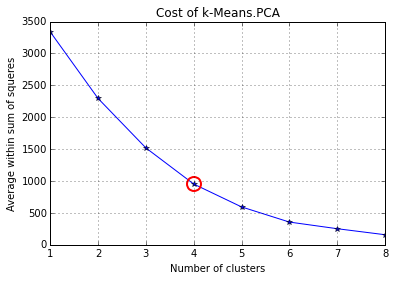

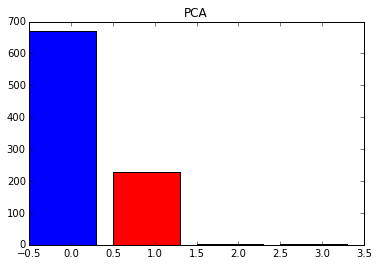

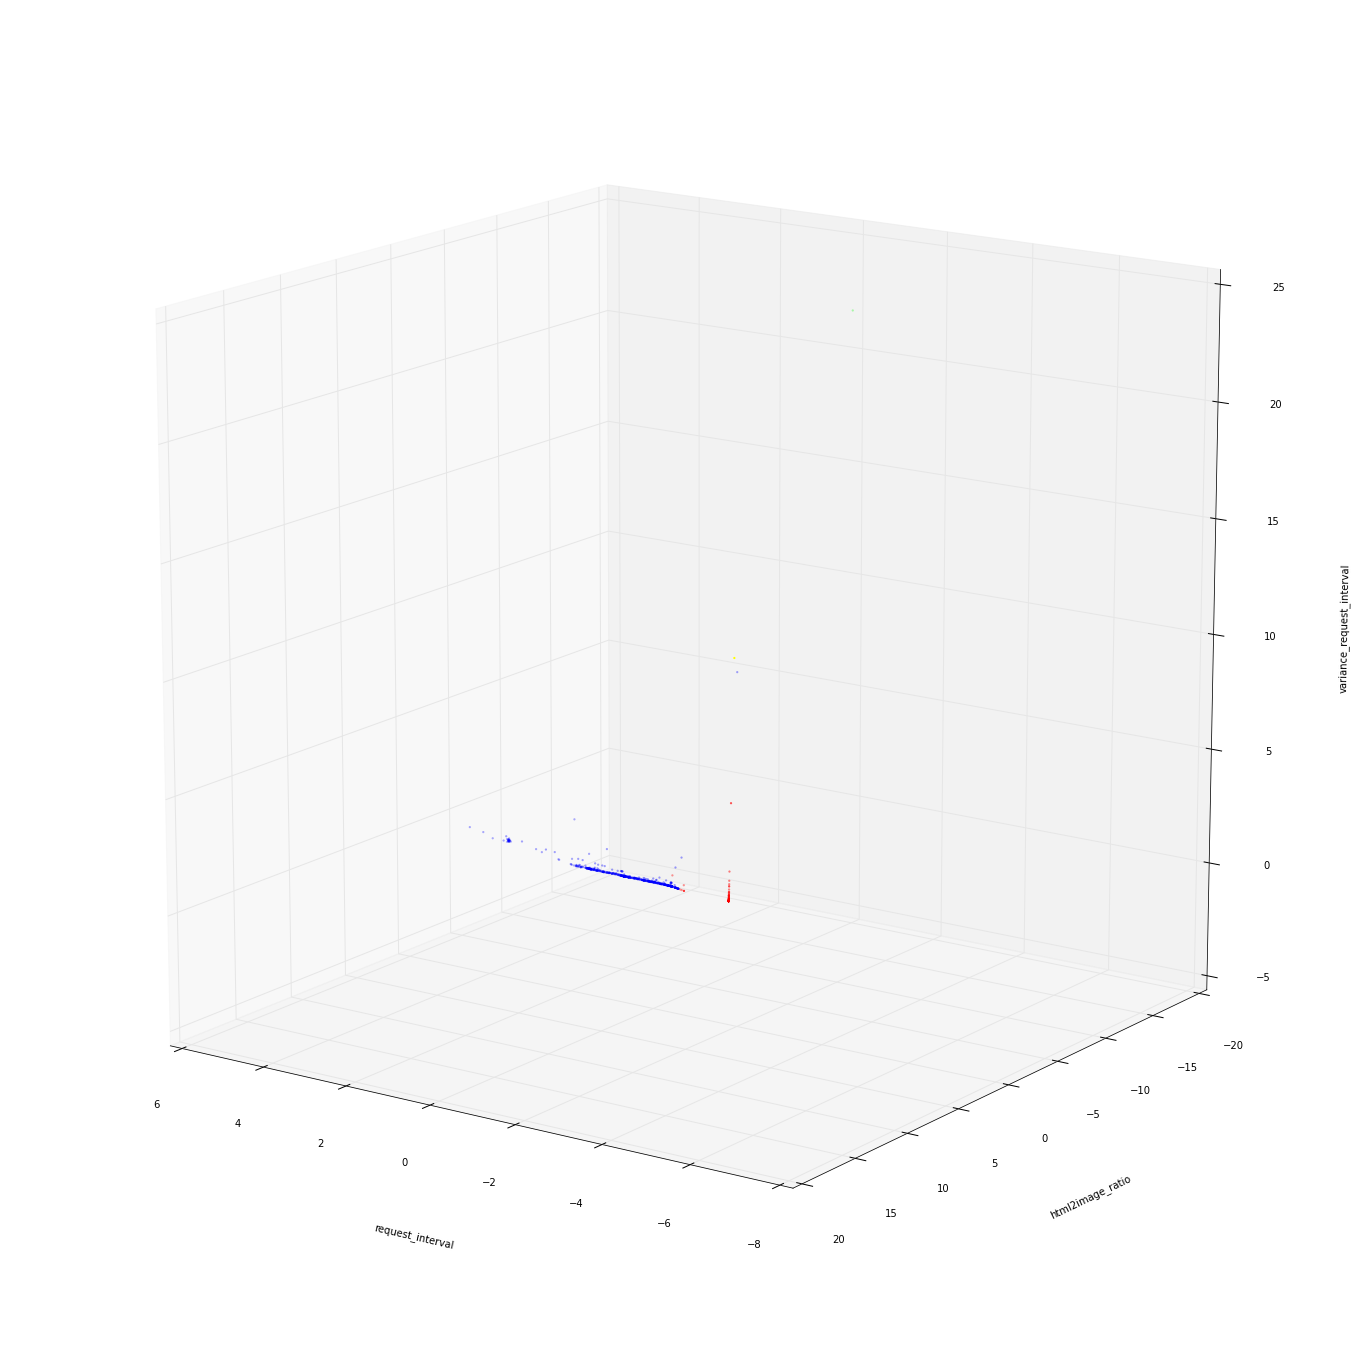

In [86]:
# perform PCA dimensionality reduction

#PCA to 3 dimensions for visualisation
pca = sklearn.decomposition.RandomizedPCA(n_components=3).fit(X)
X = pca.transform(X)

# elbow methos fpr PCA
clusters, num_clusters, costs_pca = get_best_clustering_model(X, max_number_of_clusters, "PCA")
print ("Num clusters(PCA):", num_clusters)

plot3([0,1,2], X, clusters, -1)

# DBSCAN Clustering

[3610, 6421, 484, 21, 136, 27, 65, 33, 20, 23, 31]
Estimated number of clusters: 11


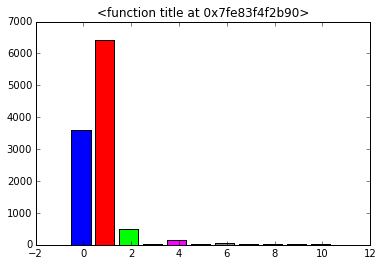

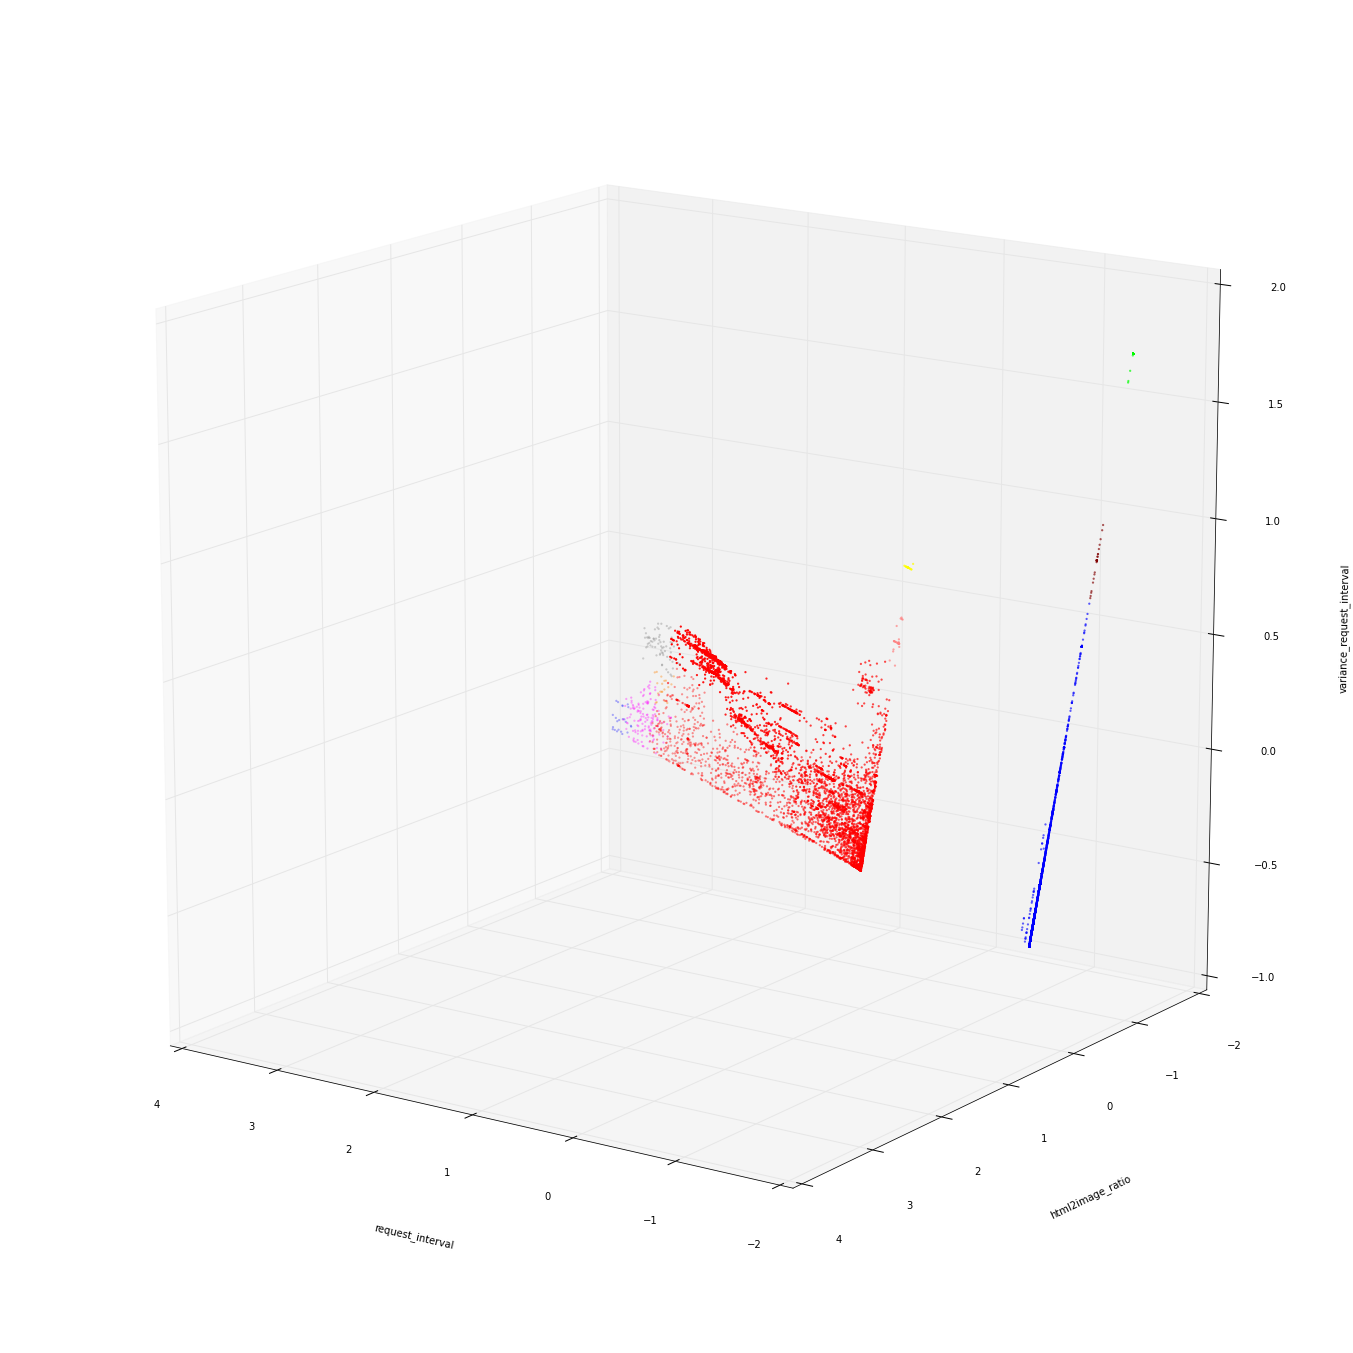

In [74]:
# DBSCAN clusterint
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=20).fit(X)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
clusters = db.labels_.astype(int)
#clusters_dbscan = clusters_dbscan.tolist()

# Number of clusters in labels, ignoring noise if present.
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

plot_clusters(clusters, num_clusters)

print('Estimated number of clusters: %d' % num_clusters)
plot3([0,1,2], X, clusters, -1)

# K-Means Clustering 

[13068]
[2046, 11022]
[6918, 1949, 4201]
[4951, 2140, 4201, 1776]
[2140, 4195, 4952, 1776, 5]
[2111, 4195, 1342, 635, 5, 4780]
[4761, 3623, 1337, 2109, 632, 5, 601]
[3623, 4592, 833, 2009, 5, 422, 601, 983]
[4951, 2140, 4201, 1776]
('Num clusters:', 4)


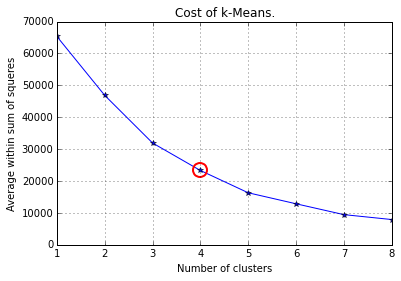

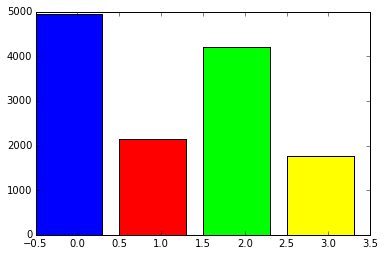

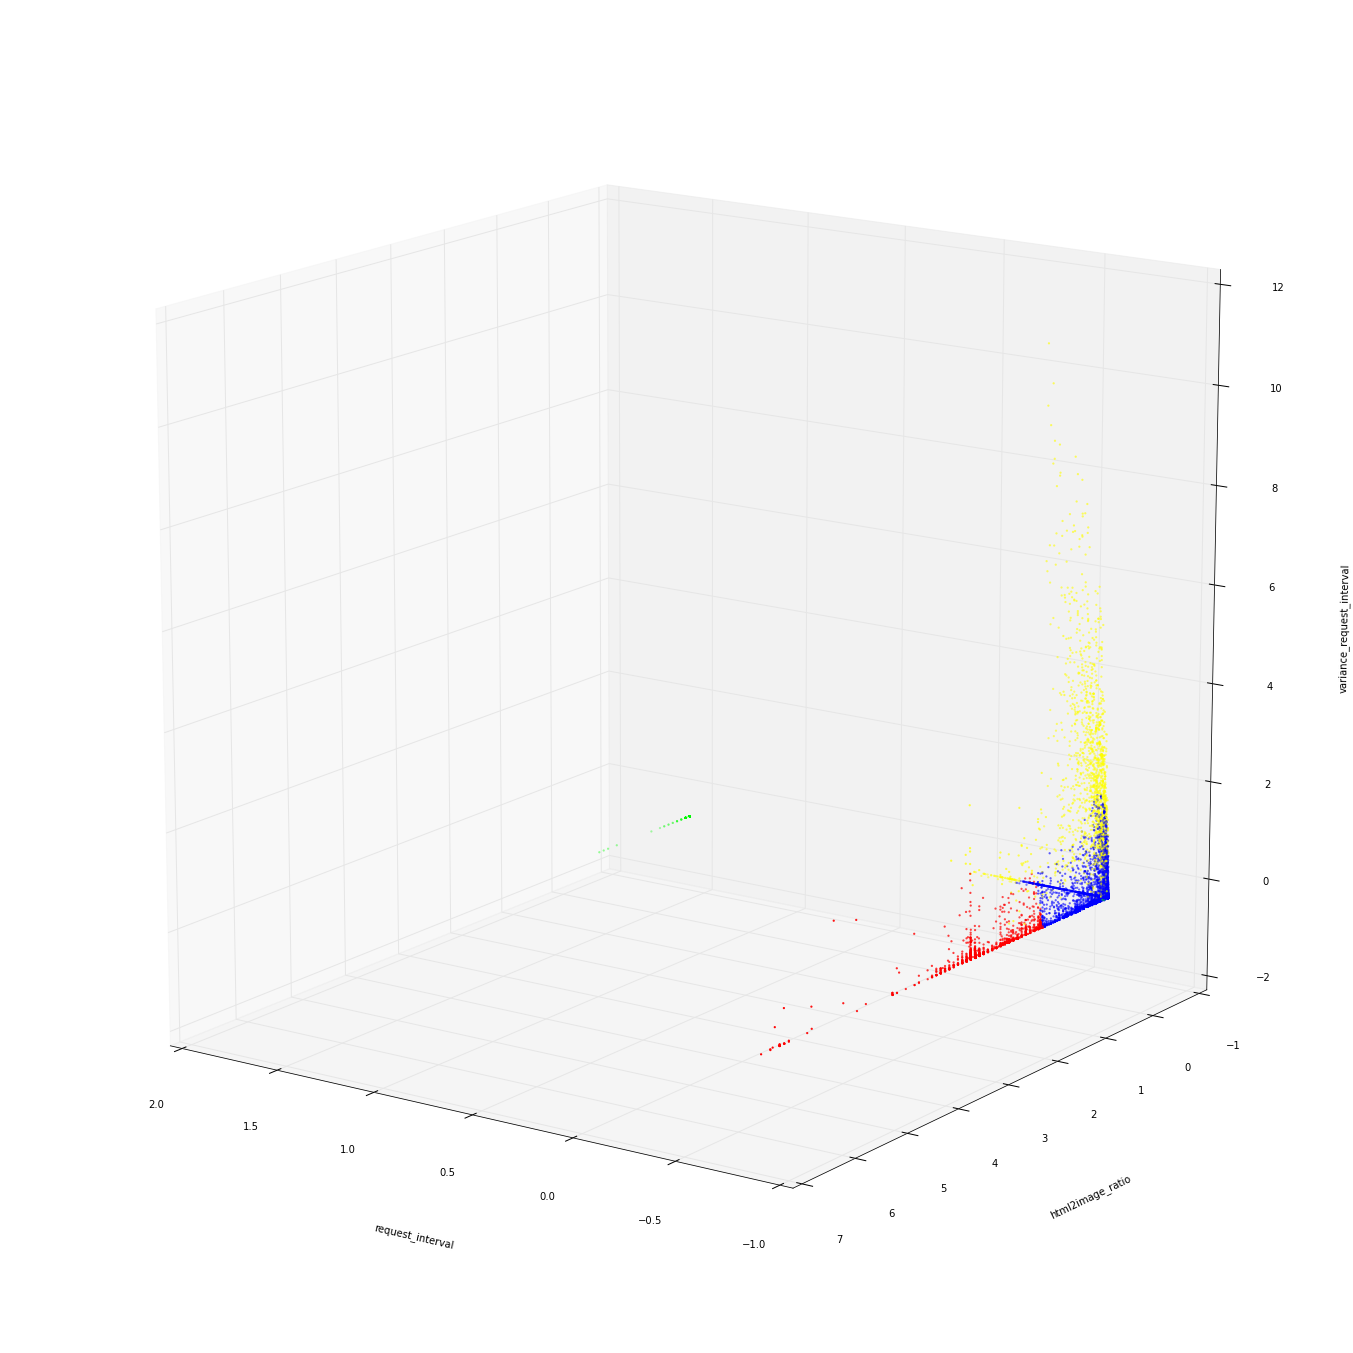

In [14]:
# K-Means
clusters, num_clusters, costs = get_best_clustering_model(X, max_number_of_clusters, "")
print ("Num clusters:", num_clusters)
plot3([0,1,2], X, clusters, -1)


# Custom Number of Clusters

[58, 311, 180, 36, 1, 313, 1]


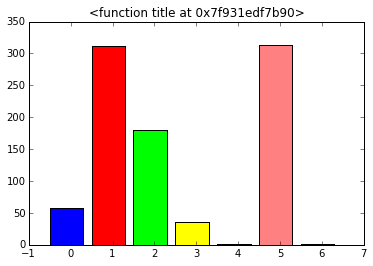

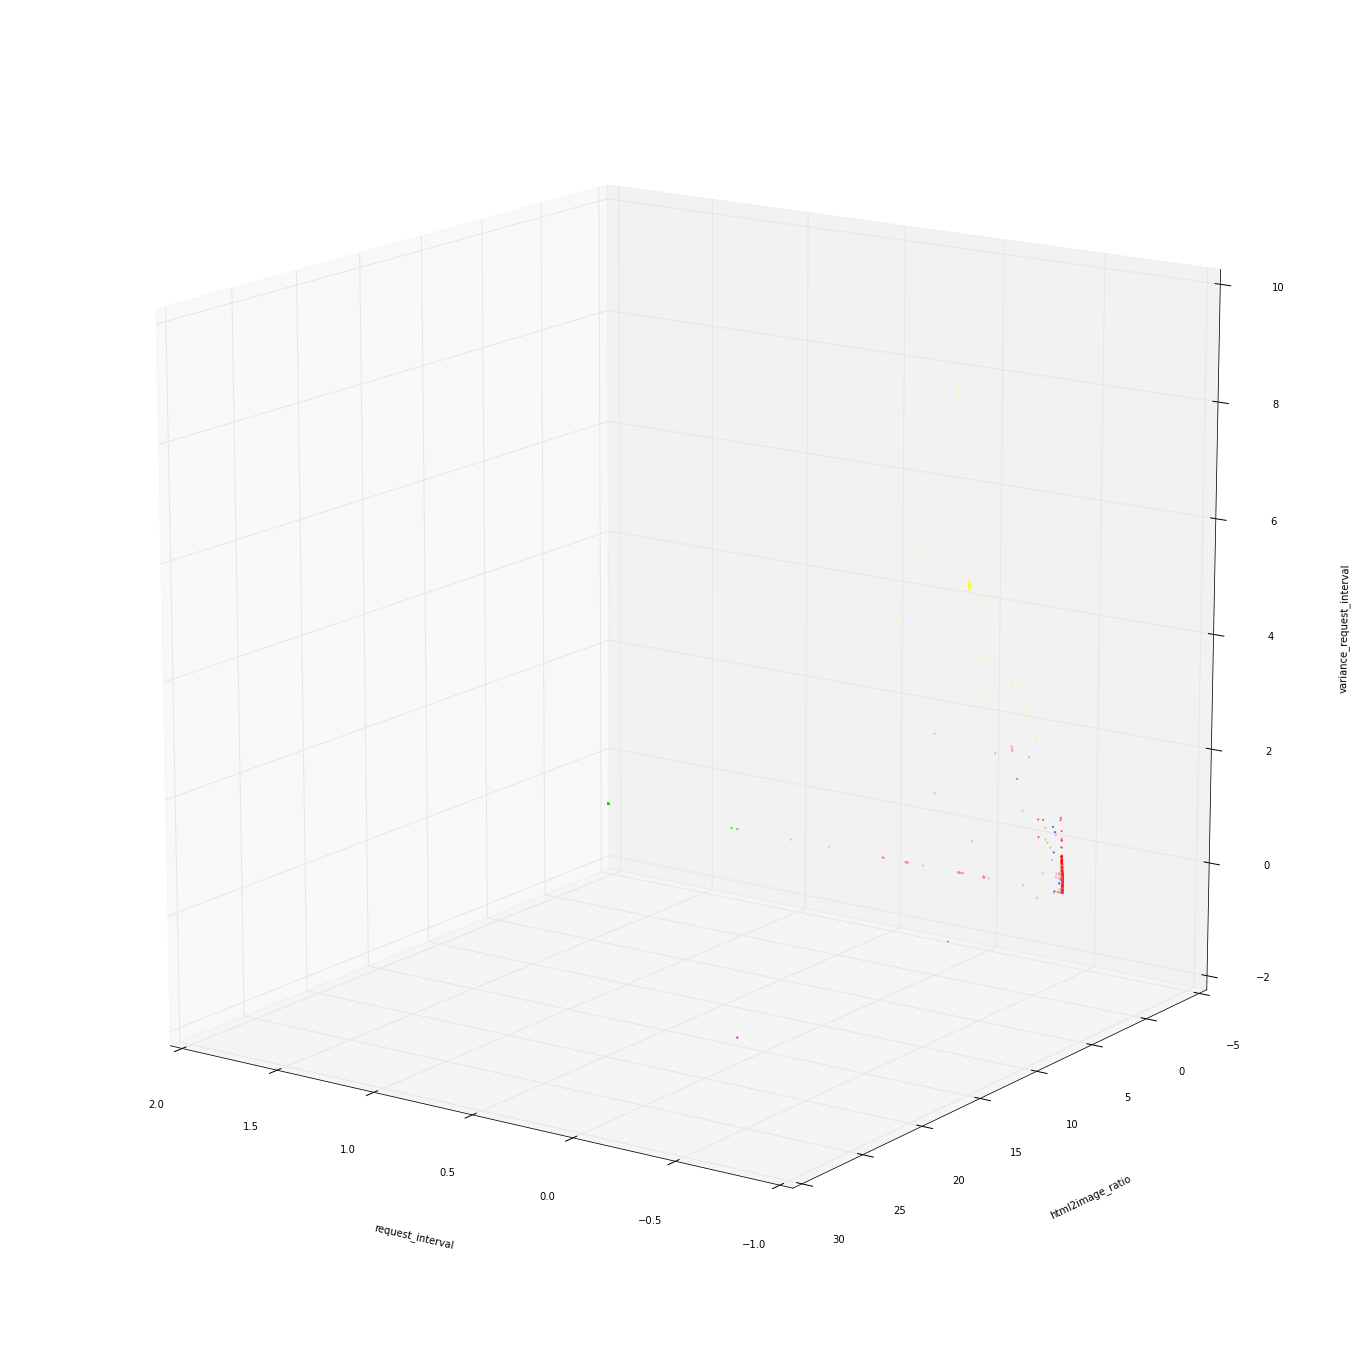

In [142]:
# custom number of clusters
num_clusters = 9
clusters = get_clustering_model(X, num_clusters)
plot3([0,1,2], X, clusters, -1)

# IP Intersection

IP intersection with anothe incident

In [15]:
# Intersection with another incident(and cluster)
plot_intersection(clusters, num_clusters, id_incident, ips, 20, -1)

/usr/local/lib/python2.7/dist-packages/bokeh/core/properties.py:453: DeprecationWarning: Setting a fixed font size value as a string '10pt' is deprecated, set with value('10pt') or ['10pt'] instead
  value = self.descriptor.prepare_value(obj.__class__, self.name, value)
/usr/local/lib/python2.7/dist-packages/bokeh/core/properties.py:453: DeprecationWarning: Setting a fixed font size value as a string '14pt' is deprecated, set with value('14pt') or ['14pt'] instead
  value = self.descriptor.prepare_value(obj.__class__, self.name, value)


/usr/local/lib/python2.7/dist-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
/usr/local/lib/python2.7/dist-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
/usr/local/lib/python2.7/dist-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
/usr/local/lib/python2.7/dist-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
/usr/local/lib/python2.7/dist-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(self):
/usr/local/lib/python2.7/dist-packages/ipykernel/comm/comm.py:24: Depre

# Countries 

In [26]:
#num_clusters = 15
#clusters = get_clustering_model(X, num_clusters)

plot_countries(clusters, num_clusters, sessions, 8)

/usr/local/lib/python2.7/dist-packages/bokeh/core/properties.py:453: DeprecationWarning: Setting a fixed font size value as a string '10pt' is deprecated, set with value('10pt') or ['10pt'] instead
  value = self.descriptor.prepare_value(obj.__class__, self.name, value)
/usr/local/lib/python2.7/dist-packages/bokeh/core/properties.py:453: DeprecationWarning: Setting a fixed font size value as a string '14pt' is deprecated, set with value('14pt') or ['14pt'] instead
  value = self.descriptor.prepare_value(obj.__class__, self.name, value)


/usr/local/lib/python2.7/dist-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
/usr/local/lib/python2.7/dist-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
/usr/local/lib/python2.7/dist-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
/usr/local/lib/python2.7/dist-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
/usr/local/lib/python2.7/dist-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(self):
/usr/local/lib/python2.7/dist-packages/ipykernel/comm/comm.py:24: Depre

# Banjax

In [160]:
# banjax ban feature
plot_ban(clusters, num_clusters, sessions)

/usr/local/lib/python2.7/dist-packages/bokeh/core/properties.py:453: DeprecationWarning: Setting a fixed font size value as a string '10pt' is deprecated, set with value('10pt') or ['10pt'] instead
  value = self.descriptor.prepare_value(obj.__class__, self.name, value)
/usr/local/lib/python2.7/dist-packages/bokeh/core/properties.py:453: DeprecationWarning: Setting a fixed font size value as a string '14pt' is deprecated, set with value('14pt') or ['14pt'] instead
  value = self.descriptor.prepare_value(obj.__class__, self.name, value)


[4, 0, 0, 92]
[0.08, 0.0, 0.0, 5.18]


/usr/local/lib/python2.7/dist-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
/usr/local/lib/python2.7/dist-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
/usr/local/lib/python2.7/dist-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
/usr/local/lib/python2.7/dist-packages/ipykernel/comm/comm.py:32: DeprecationWarning: Comm._session_default is deprecated: use @default decorator instead.
  def _session_default(self):
/usr/local/lib/python2.7/dist-packages/ipykernel/comm/comm.py:41: DeprecationWarning: Comm._topic_default is deprecated: use @default decorator instead.
  def _topic_default(self):
/usr/local/lib/python2.7/dist-packages/ipykernel/comm/comm.py:24: Depre

# Save Clustering

In [ ]:
# saving clustering
tools.save_clustering(sessions, clusters)

# Save Selected Cluster

In [ ]:
selected_cluster = 1
tools.save_selected_cluster(id_incident, selected_cluster)